# Exercises

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from pywt import scale2frequency
from pywt import cwt
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.stats import zscore

## Exercise 1: explore filter parameters
---
In this exercises you will explore how different parameters affect the filtering process.
- Import the data form `data/moving_lfp.pickle` (the file is already on your machine if you run the `download_data()` cell in the main lesson)
- Take a few seconds of the data, and filter them in different frequency bands. Plot the resulting singal.
  Fix the central frequency and play with the width of the band, then try to change the central frequency of the band.
- Change the order of the filter, keeping the frequency band fixed. How does the filtered signal change? How does the computing time change? (You can try to quantify the computing time with the jupyter magic command [`%timeit`](https://docs.python.org/3/library/timeit.html) )
- Comment on what you see

In [2]:
# Import the data
with open('data/moving_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)

lfp = lfp_data['lfp']
sampling_rate = lfp_data['sampling_rate']
print(f'Loaded {len(lfp)/sampling_rate} seconds of LFP, sampled at {sampling_rate} Hz')

Loaded 600.133 seconds of LFP, sampled at 1000.0 Hz


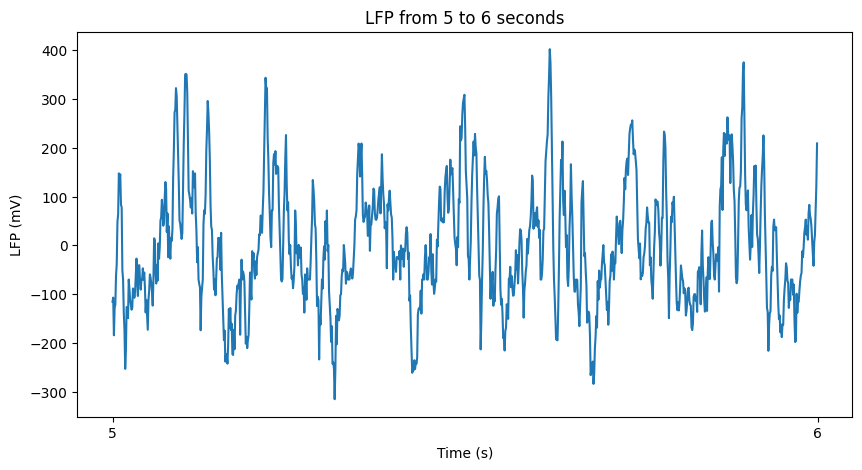

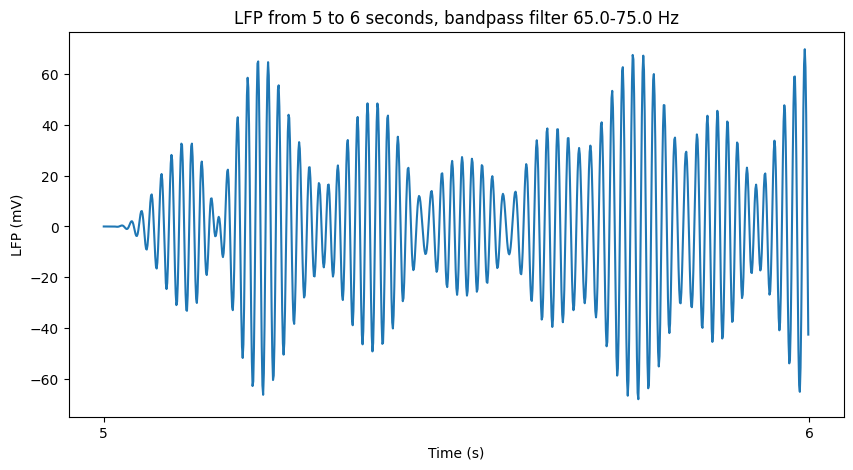

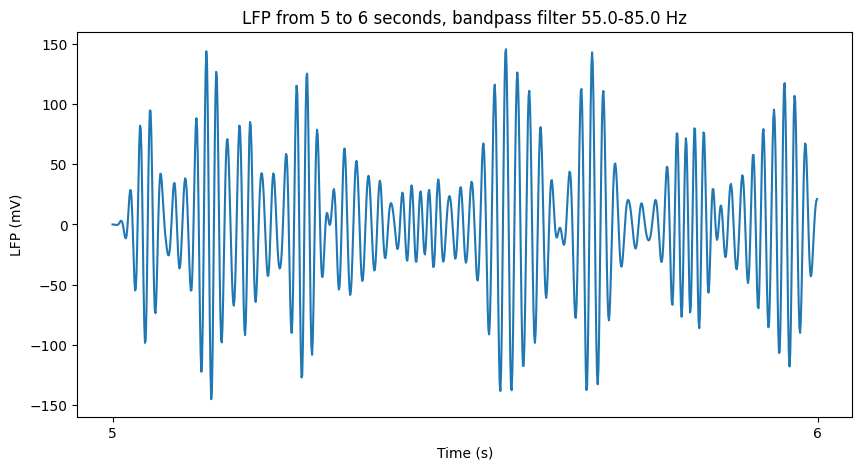

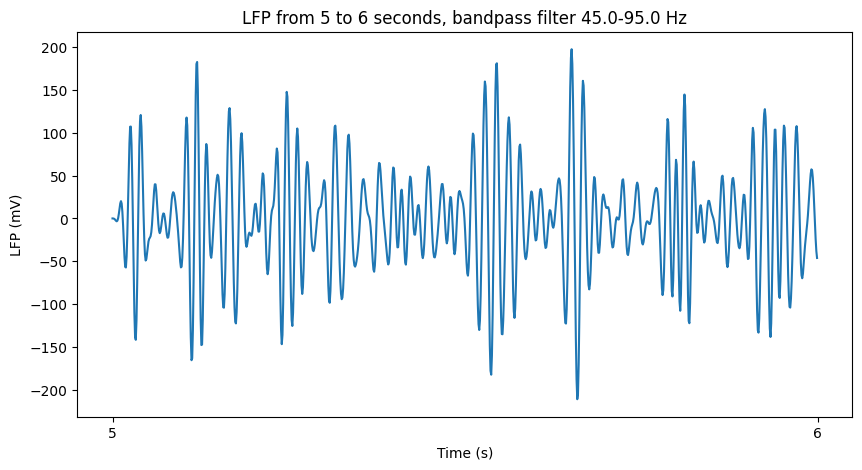

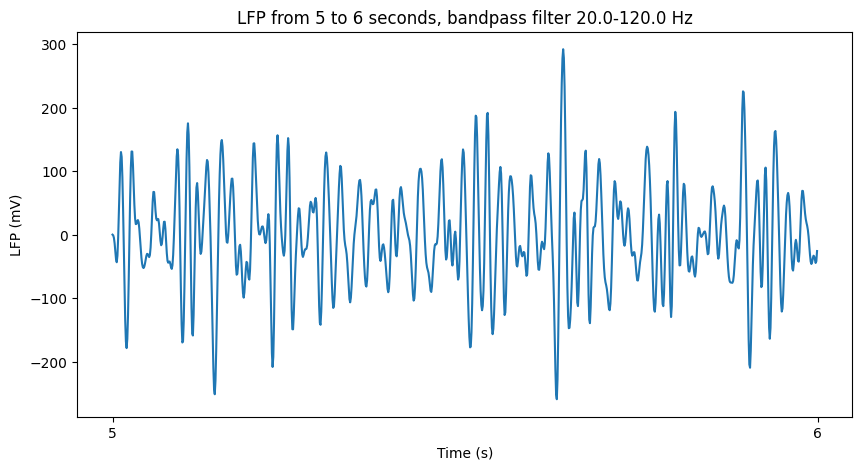

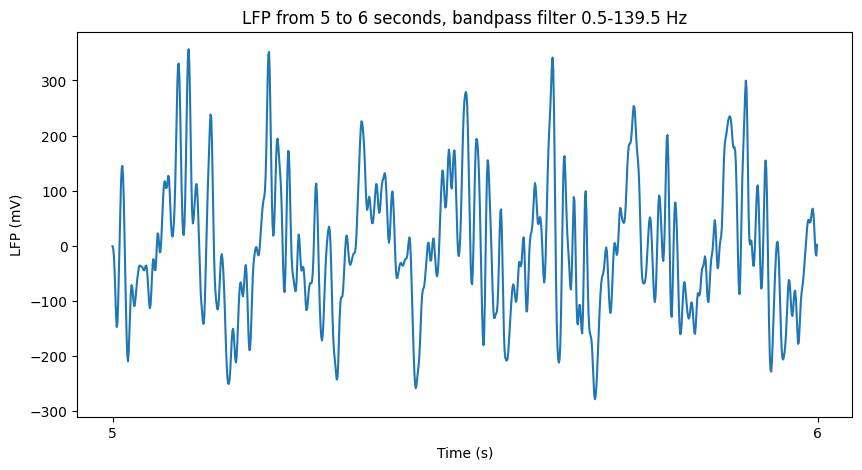

In [3]:
# Take a few seconds of the data
start = 5
end = 6
lfp_part = lfp[int(start*sampling_rate): int(end*sampling_rate)]
lfp_part = lfp_part - np.mean(lfp_part)

# Plot the truncated LFP
plt.figure(figsize=(10,5))
plt.plot(lfp_part)
plt.xlabel('Time (s)')
plt.xticks(np.arange(0, len(lfp_part)+1000, sampling_rate), np.arange(start, end+1))
plt.ylabel('LFP (mV)')
plt.title(f'LFP from {start} to {end} seconds')
plt.show()

# Fix a central frequency 70 Hz, try different bandwidths (10, 30, 50, 100, 139 Hz)
central_freq = 70
bandwidths = [10, 30, 50, 100, 139]
filter_order = 5
for bandwidth in bandwidths:
    # Compute the bandpass filter
    filter = signal.butter(filter_order, [central_freq-bandwidth/2, central_freq+bandwidth/2], btype='bandpass', output='sos', fs=sampling_rate)
    # Apply the filter
    lfp_filtered = signal.sosfilt(filter, lfp_part)
    # Plot the filtered LFP
    plt.figure(figsize=(10,5))
    plt.plot(lfp_filtered)
    plt.xlabel('Time (s)')
    plt.xticks(np.arange(0, len(lfp_part)+1000, sampling_rate), np.arange(start, end+1))
    plt.ylabel('LFP (mV)')
    plt.title(f'LFP from {start} to {end} seconds, bandpass filter {central_freq-bandwidth/2}-{central_freq+bandwidth/2} Hz')
    plt.show()

Filter order 1
361 µs ± 15.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
46.8 µs ± 1.22 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Filter order 2
539 µs ± 11.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
46.8 µs ± 1.34 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Filter order 3
718 µs ± 24.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
46.1 µs ± 929 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Filter order 4
819 µs ± 16.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
46.3 µs ± 1.55 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Filter order 5
1.01 ms ± 25.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
45.9 µs ± 664 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


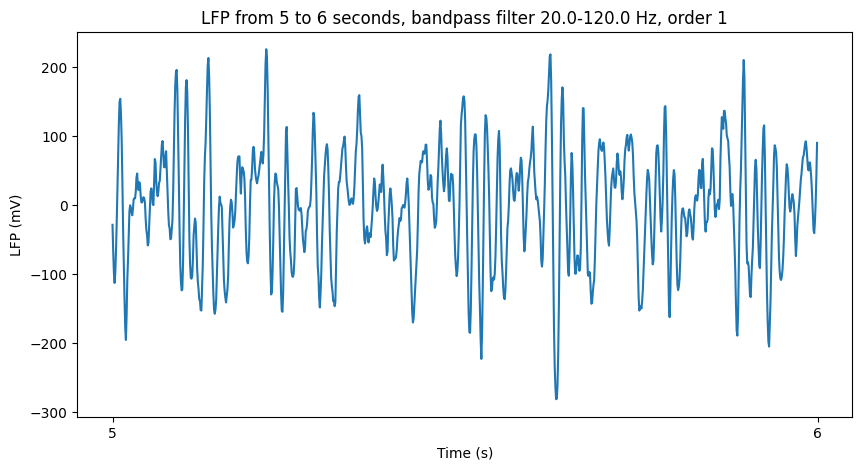

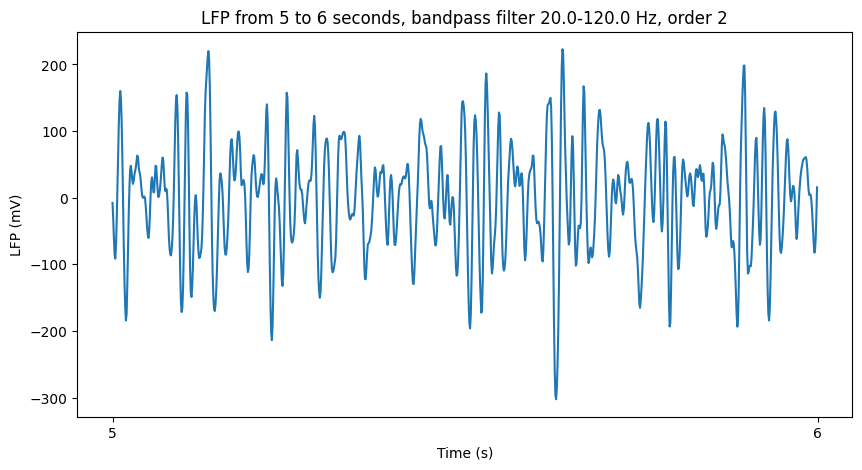

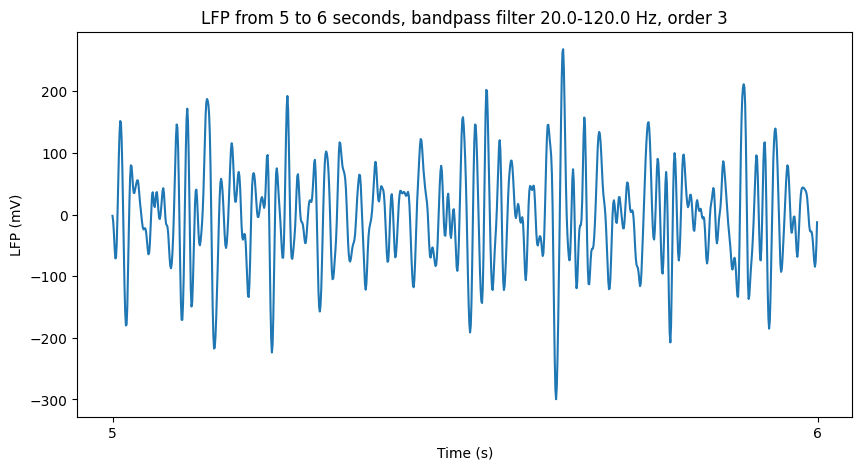

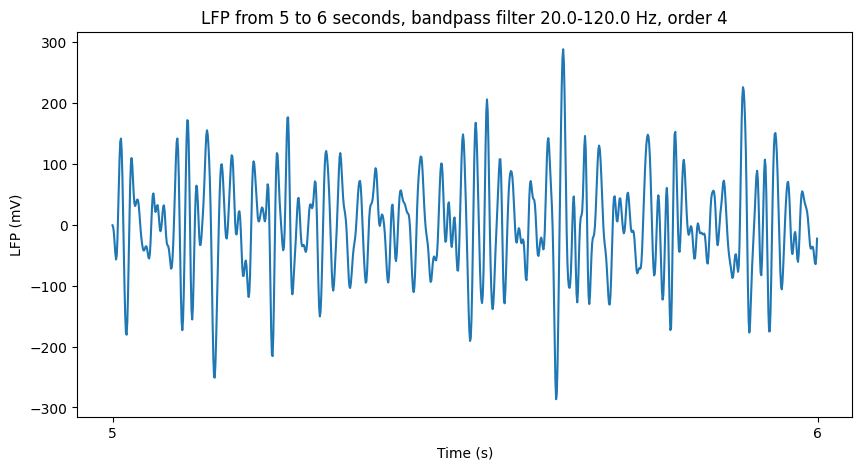

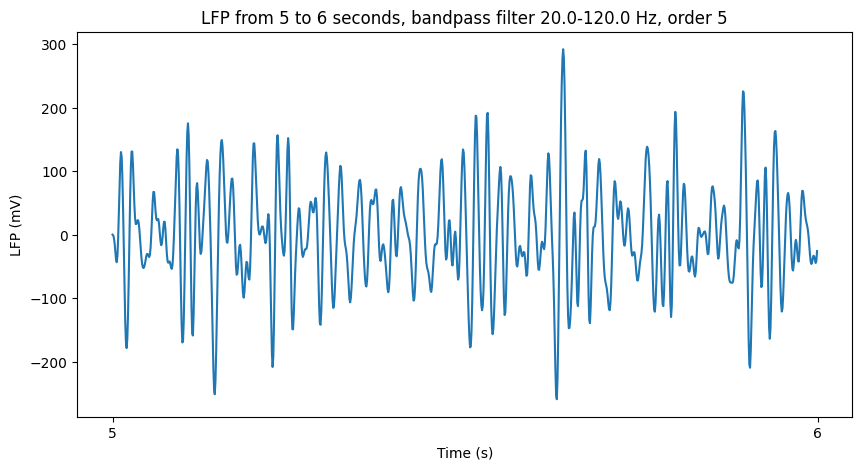

In [4]:
# Keep the 70 Hz bandpass filtered LFP, with a bandwidth of 100 Hz; experiment with different filter orders (1, 2, 3, 4, 5)
central_freq = 70
bandwidths = 100
filter_orders = [1, 2, 3, 4, 5]
all_lfp_filtered = []

for filter_order in filter_orders:
    # Compute the bandpass filter
    filter = signal.butter(filter_order, [central_freq-bandwidths/2, central_freq+bandwidths/2], 
                           btype='bandpass', output='sos', fs=sampling_rate)
    # Apply the filter
    lfp_filtered = signal.sosfilt(filter, lfp_part)
    all_lfp_filtered.append(lfp_filtered.copy())

timing = True
if timing:
    for filter_order in filter_orders:
        print(f'Filter order {filter_order}')
        %timeit filter = signal.butter(filter_order, [central_freq-bandwidths/2, central_freq+bandwidths/2], btype='bandpass', output='sos', fs=sampling_rate)
        %timeit lfp_filtered = signal.sosfilt(filter, lfp_part)

# Plot the filtered LFPs
for i, lfp_filtered in enumerate(all_lfp_filtered):
    plt.figure(figsize=(10,5))
    plt.plot(lfp_filtered)
    plt.xlabel('Time (s)')
    plt.xticks(np.arange(0, len(lfp_part)+1000, sampling_rate), np.arange(start, end+1))
    plt.ylabel('LFP (mV)')
    plt.title(f'LFP from {start} to {end} seconds, bandpass filter {central_freq-bandwidths/2}-{central_freq+bandwidths/2} Hz, order {i+1}')
    plt.show()

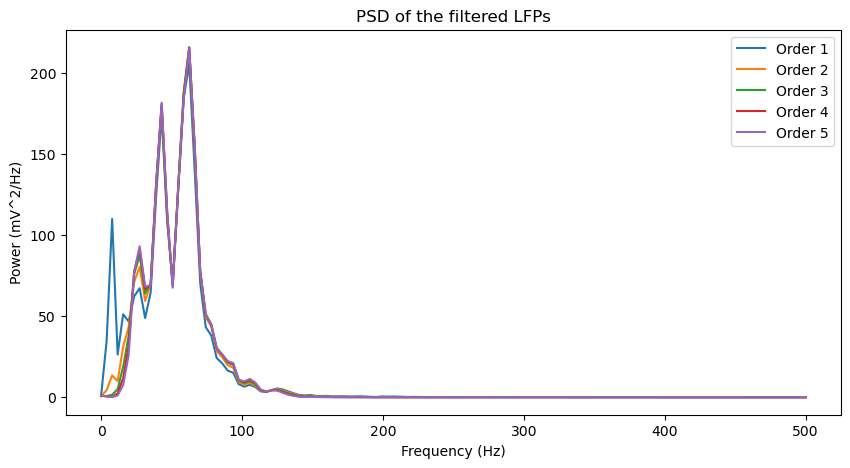

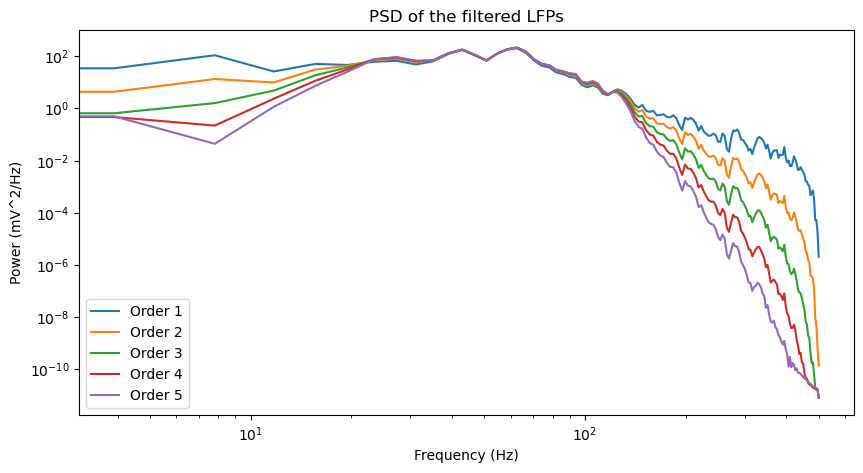

In [5]:
# Compute the power spectrum of the filtered LFPs
all_psd = []
for lfp_filtered in all_lfp_filtered:
    f, Pxx = signal.welch(lfp_filtered, sampling_rate)
    all_psd.append(Pxx.copy())

# Draw the linear and loglog plot of power spec of the filtered LFPs, for each filter order
plt.figure(figsize=(10,5))
for i, Pxx in enumerate(all_psd):
    plt.plot(f, Pxx, label=f'Order {filter_orders[i]}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (mV^2/Hz)')
plt.title('PSD of the filtered LFPs')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
for i, Pxx in enumerate(all_psd):
    plt.loglog(f, Pxx, label=f'Order {filter_orders[i]}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (mV^2/Hz)')
plt.title('PSD of the filtered LFPs')
plt.legend()
plt.show()

<div class="alert alert-block alert-info">

**Report for Exercise 1**

- To experiment with different bandwidth values of filters, I fix a central frequency 70 Hz and try different bandwidths (10, 30, 50, 100, 139 Hz).
    - With narrower bandwidth (e.g., 10 Hz), only a few frequency components are kept, so the signal looks very "regular", oscillating with a nearly constant frequency.
    - With broader bandwidth (e.g., 100 or 139 Hz), many frequency components are kept. So the filtered signals look more similar to the original signal, which is less "regular" in shape.
<br/><br/>
- With higher order filters, there are less high-frequency oscillations in the signal, so the signal looks a bit more smooth. From the frequency domain plots, it can be seen that beyond the filter bandwidth, higher order filters make the signal decay faster. By timing the computations, I find that higher order filters require more time for computation. For example, 1st order filter takes 121 us, while 5th order filter takes 340 us.

### FPB comments
*Code is up to standard. Exploration of multiple frequency bands is missing but is a trivial variation on the code that you did. I kind of disagree with your comments on the differences between different orders... I would say that the main difference is in the low frequencies that are more preserved by the lower orders. This is because your passband is [20 120] and there is a peak probably around 8 Hz. The frequency response of a low order filter decays quite slowly, so the 8 Hz leak in. Grade: 8*

## Exercise 2: wavelet transform with real wavelets
---
In this exercises you will explore the difference between real and complex wavelets in the continous wavelet transform.
- Import the data form `data/moving_lfp.pickle`
- Select a period of a few seconds of the signal and compute the spectrogram. 
  Try the wavelet transform with wavelet `mexh` (mexican hat),`gaus` (gaussian) and `morl` (morlet). These are all real wavelets.
- What differences do you see with respect to the spectrum computed with the complex Morlet tranform ? Comment on why do you think this might be the case.

In [8]:
# Import the data
with open('data/moving_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)

lfp = lfp_data['lfp']
sampling_rate = lfp_data['sampling_rate']
print(f'Loaded {len(lfp)/sampling_rate} seconds of LFP, sampled at {sampling_rate} Hz')

start = 5
end = 6
lfp_part = lfp[int(start*sampling_rate): int(end*sampling_rate)]
lfp_part = lfp_part - np.mean(lfp_part)

Loaded 600.133 seconds of LFP, sampled at 1000.0 Hz


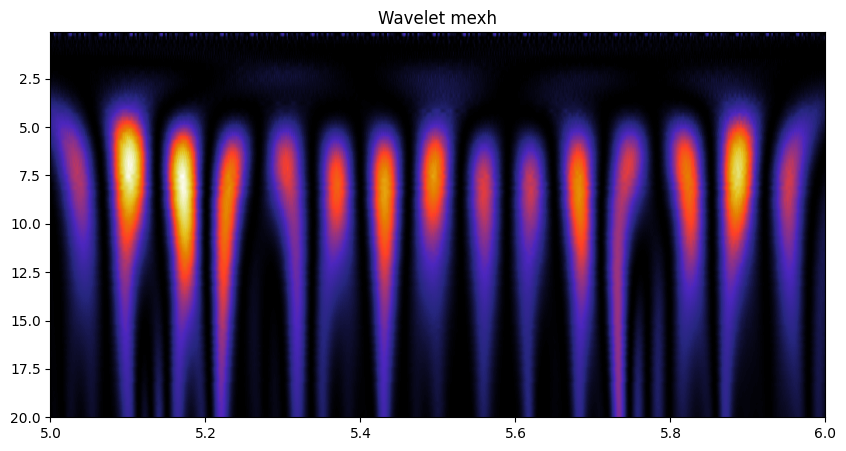

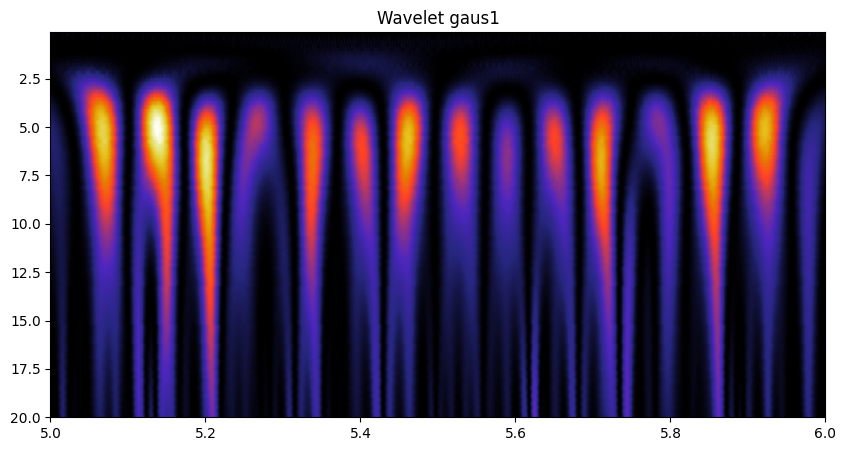

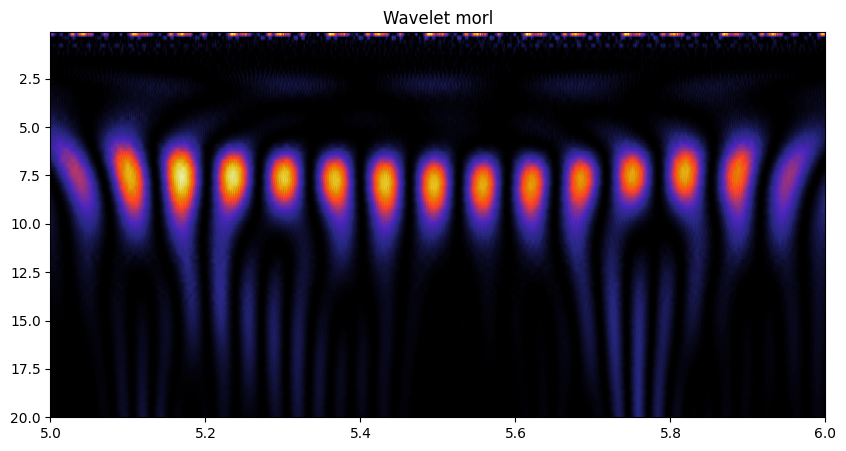

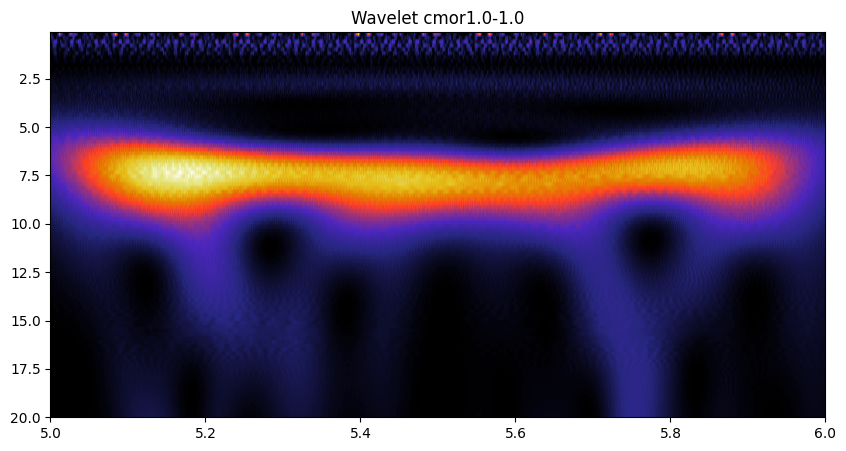

In [9]:
def plot_wavelet(wavelet, sampling_rate, frequencies):
    scales = scale2frequency(wavelet, frequencies)
    cwtmatr, _ = cwt(lfp_part, wavelet=wavelet, scales=scales,
                    sampling_period=1.0/sampling_rate)
    plt.figure(figsize=(10,5))
    plt.title(f'Wavelet {wavelet}')
    plt.imshow(abs(cwtmatr)**2, extent=[start,end,frequencies[-1]*sampling_rate,
                            frequencies[0]*sampling_rate], aspect='auto', cmap='CMRmap')
    
frequencies =  np.linspace(0.1,20,100)/sampling_rate
wavelet = ['mexh', 'gaus1', 'morl', 'cmor1.0-1.0']
for i in range(len(wavelet)):
    plot_wavelet(wavelet[i], sampling_rate, frequencies)

<div class="alert alert-block alert-info">

**Report for Exercise 2**

With real-value wavelets, the "hot spots" on the time-frequency plots look discrete; while with the complex wavelet, the plot looks more continuous. This is because real-value wavelets ignore the signal components with 90-degree phase shift (i.e., only the cosine parts are taken into consideration). While with complex wavelet, we can consider both the sine and cosine parts, avoiding information loss due to phase differences.

### FPB comments
*Code is up to standard, except that plots should have axis labels, colorbars etc.) Comments are spot on. Grade: 8*

## Exercise 3: REM sleep detection
---
Mammalian sleep is organized in different phases. [Rapid Eye Movement (REM) sleep](https://en.wikipedia.org/wiki/Rapid_eye_movement_sleep) is a well studied phase, with clear markers that make it detectable from LFP data. One of the most used marker is the ratio (or difference) between the oscillatory power in the theta and delta bands in the hippocampus. During REM sleep, the former dominates, in a pattern that resembles active behaviour.  
In this exercise we will use the tools we learned about to detect and inspect the REM and non-REM (nREM) phases of sleep in data recorded from the hippocampus of a sleeping mouse.

- Import the data form `data/moving_lfp.pickle`
- Compute the instantaneous power in the theta (6-10 Hz) and delta (2-4 Hz) frequency bands, for the whole signal.
- z-score the two power signals (subtract the mean and divide by the standard deviation, you can use `scipy.stats.zscore()`)
- Compute and plot the power difference (`theta_power - delta_power`) for the sleep session.
- Compute the REM (power difference $>0.2$) and nREM (power diffewrence $<0.2$) sleep periods.
- Plot examples of REM vs nREM lfp signals (wideband filtered betw. 1 and 200 Hz to get rid of some of the noise).
- Explore how changing the threshold affects the amount of REM sleep detected.

In [8]:
# Import the data
with open('data/moving_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)

lfp = lfp_data['lfp']
sampling_rate = lfp_data['sampling_rate']
print(f'Loaded {len(lfp)/sampling_rate} seconds of LFP, sampled at {sampling_rate} Hz')

lfp = lfp - np.mean(lfp)

Loaded 600.133 seconds of LFP, sampled at 1000.0 Hz


In [11]:
# Use wavelet transform to compute instantaneous power
# Theta band: 6-10 Hz
frequencies =  np.linspace(6,10,100)/sampling_rate
scales = scale2frequency('cmor1.0-1.0', frequencies)
cwtmatr, _ = cwt(lfp, wavelet='cmor1.0-1.0', scales=scales, sampling_period=1.0/sampling_rate)
theta_power = abs(cwtmatr)**2
# Delta band: 2-4 Hz
frequencies =  np.linspace(2,4,100)/sampling_rate
scales = scale2frequency('cmor1.0-1.0', frequencies)
cwtmatr, _ = cwt(lfp, wavelet='cmor1.0-1.0', scales=scales, sampling_period=1.0/sampling_rate)
delta_power = abs(cwtmatr)**2

# Load the saved *.npy data
# theta_power = np.load('data/theta_power.npy')
# delta_power = np.load('data/delta_power.npy')

theta_power = np.sum(theta_power, axis=0)
delta_power = np.sum(delta_power, axis=0)

theta_z = zscore(theta_power)
delta_z = zscore(delta_power)

power_diff = theta_z - delta_z

### FPB comments 
*you haven't included the saved theta_power and delta_power, so the code gave error. It would be nice to have a switch, so that it is clear to the user that you ahve to recreate the data*

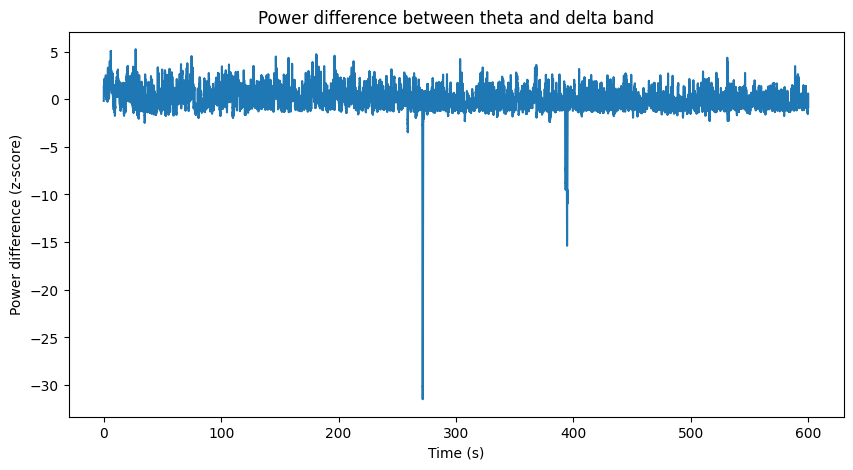

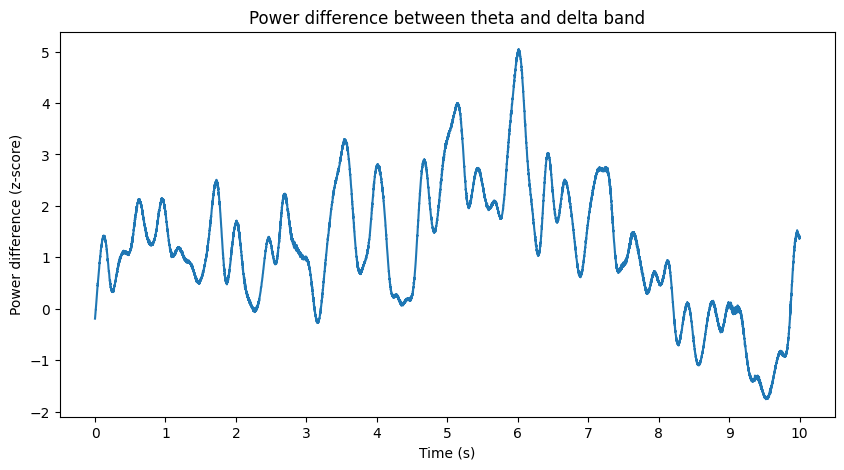

In [12]:
# Plot the power difference for the whole recording session
plt.figure(figsize=(10,5))
plt.plot(power_diff)
plt.xlabel('Time (s)')
plt.xticks(np.arange(0, len(lfp)+1000, sampling_rate*100), np.arange(0, 601, 100))
plt.ylabel('Power difference (z-score)')
plt.title('Power difference between theta and delta band')
plt.show()

# Plot the power difference for the first 10 seconds
plt.figure(figsize=(10,5))
plt.plot(power_diff[:10000])
plt.xlabel('Time (s)')
plt.xticks(np.arange(0, 11000, sampling_rate), np.arange(0, 11))
plt.ylabel('Power difference (z-score)')
plt.title('Power difference between theta and delta band')
plt.show()

In [11]:
# Find REM and NREM
rem = np.where(np.abs(power_diff) > 0.2)[0]
nrem = np.where(np.abs(power_diff) <= 0.2)[0]

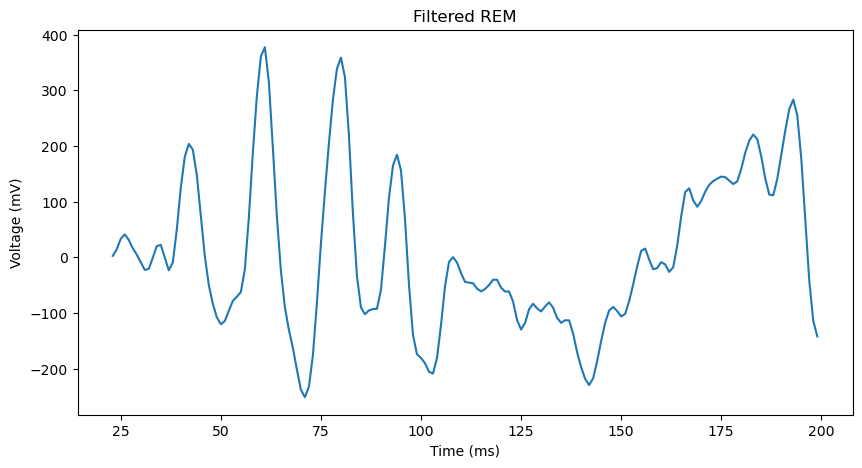

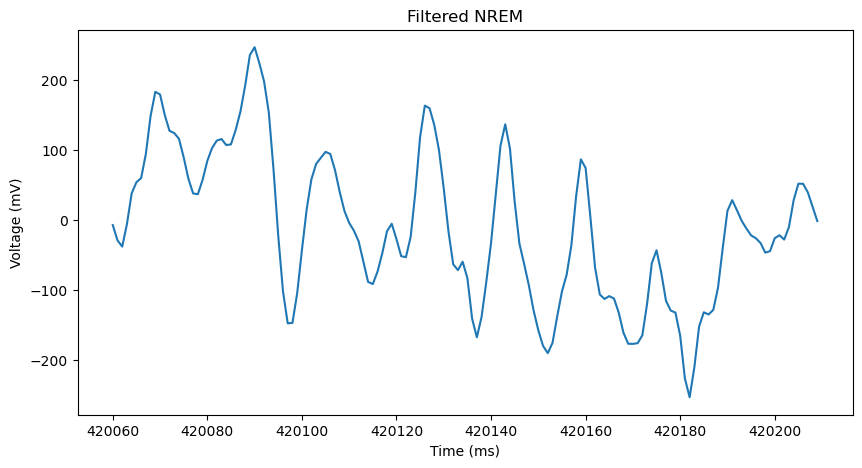

In [20]:
# Example plots: REM (23 to 200 ms) and NREM (420060 to 420210 ms)

sample_rem = lfp[23:200]
rem_range = np.arange(23, 200)
sample_nrem = lfp[420060:420210]
nrem_range = np.arange(420060, 420210)

# Filter the LFPs
filter_order = 3
band = [1, 200]
sampling_rate = 1000
filter = signal.butter(filter_order, band, btype='bandpass', output='sos', fs=sampling_rate)
sample_rem_filtered = signal.sosfilt(filter, sample_rem)
sample_nrem_filtered = signal.sosfilt(filter, sample_nrem)

# Plot the filtered LFPs
plt.figure(figsize=(10,5))
plt.plot(rem_range, sample_rem_filtered)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.title('Filtered REM')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(nrem_range, sample_nrem_filtered)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.title('Filtered NREM')
plt.show()

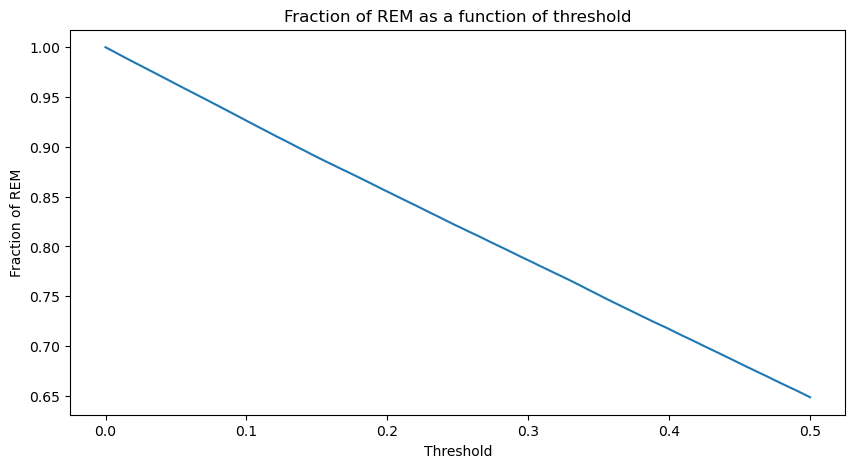

In [25]:
def rem_frac(power_diff, threshold):
    rem = np.where(np.abs(power_diff) > threshold)[0]
    return len(rem)/len(power_diff)

thresholds = np.linspace(0, 0.5, 100)
rem_fractions = []
for threshold in thresholds:
    rem_fractions.append(rem_frac(power_diff, threshold))

plt.figure(figsize=(10,5))
plt.plot(thresholds, rem_fractions)
plt.xlabel('Threshold')
plt.ylabel('Fraction of REM')
plt.title('Fraction of REM as a function of threshold')
plt.show()

<div class="alert alert-block alert-info">

**Report for Exercise 3**

- To compute the instantaneous power, I perform the wavelet transform with the complex morlet wavelet. To get the power of a frequency band, I take the summation over the band. Then, I take the z-score of the power signals, and calculate the power differences.
- Without further smoothing procedures, there are large fluctuations between the REM and nREM periods. Using Gaussian smoothing (in the future) could help resolve this issue.
- By looking at the example plots of REM and nREM LFP signals, I find the the REM period have more higher-frequency oscillations.
- By experimenting with different thresholds, I find that with increasing thresholds, the fraction of REM in the signal decreases linearly.

### FPB comments
*Code is OK. Some amount of smoothing would have been needed in order to see meaningful (longer) periods of REM and NREM, but, on the other hand, we should ahve told you... Grade: 8*